In [46]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import treebank
from nltk.grammar import induce_pcfg
from nltk import Nonterminal, ProbabilisticProduction
from nltk.parse import ViterbiParser

import time
from tqdm import tqdm

from devoir4 import *
import matplotlib.pyplot as plt

### Grab the data

In [56]:
column_names = ["Source_Code", "Acceptability_Label", "Acceptability_Judgment", "Sentence"]
df = pd.read_csv(r"C:\Users\Louis\Documents\University\Masters\A23\NLP\Devoirs\ift6285-devoirs\data\CoLA\dev.tsv", delimiter='\t', header=None, names=column_names)

problematic_sentences_df = df[df['Acceptability_Label'] == 0]
problematic_sentences_df.head()

,Source_Code,Acceptability_Label,Acceptability_Judgment,Sentence
4,cj99,0,*,"As you eat the most, you want the least."
5,cj99,0,*,"The more you would want, the less you would eat."
6,cj99,0,*,"I demand that the more John eat, the more he p..."
13,cj99,0,*,"The more does Bill smoke, the more Susan hates..."
16,bc01,0,*,Who does John visit Sally because he likes?


With the problematic sentences

In [57]:
problematic_sentences = problematic_sentences_df["Sentence"].reset_index(drop=True)
problematic_sentences = problematic_sentences.str.lower()

problematic_sentences.str.count(" ").describe().round(2)

count    322.00
mean       6.85
std        4.07
min        1.00
25%        4.00
50%        6.00
75%        9.00
max       26.00
Name: Sentence, dtype: float64

In [100]:
# Get the known productions
productions = get_PTB_produtions()

# Get the known words
ptb_sentences = treebank.sents()
known_words = set(word.lower() for sentence in ptb_sentences for word in sentence)

# Replace unknown words with UNK
unk_token = 'UNK'
modified_sentences = []
for sentence in problematic_sentences:
    words = nltk.word_tokenize(sentence)

    modified_words = [word if word.lower() in known_words else unk_token for word in words]
    modified_sentence = ' '.join(modified_words)
    modified_sentences.append(modified_sentence)
    

[nltk_data] Downloading package treebank to
[nltk_data]     C:\Users\Louis\AppData\Roaming\nltk_data...
[nltk_data]   Package treebank is already up-to-date!


### Add the UNK rules

In [101]:
non_terminals = set([Nonterminal(nt) for sent in modified_sentences for nt in sent.split() if isinstance(Nonterminal(nt), Nonterminal)])

for non_terminal in non_terminals:
    productions.append(ProbabilisticProduction(non_terminal, [unk_token]))
productions.append(ProbabilisticProduction(Nonterminal("UNK"), [unk_token]))

for sent in modified_sentences:
    tokens = nltk.word_tokenize(sent)
    for token in tokens:
        productions.append(ProbabilisticProduction(Nonterminal(token), [f"{token}"]))

### Create the grammar & the parser

In [102]:
full_grammar = induce_pcfg(Nonterminal("S"), productions)
parser = ViterbiParser(full_grammar)

In [103]:
modified_sentences = pd.Series(modified_sentences)
modified_sentences

0             as you eat the most , you want the least .
1      the more you would want , the less you would e...
2      i demand that the more john eat , the more he ...
3      the more does bill smoke , the more susan UNK ...
4               who does john visit UNK because he UNK ?
                             ...                        
317                          it is to give up to leave .
318    it was believed to be illegal by them to do th...
319                         i gave UNK the book to UNK .
320                   i presented bill with it to read .
321         john bought a UNK for himself to play with .
Length: 322, dtype: object

In [133]:
parse_dict = {}
nb_sent_dict = {}
nb_parses_dict = {}
nb_unkwords_dict = {}

# 1, 26 = min, max number of words for the problematic sentences. Add 1 to get the number of words, as this counts the number of SPLITS.
for length_threshhold in range(1, 26): 
    mod_sent_filt = modified_sentences[modified_sentences.str.count(" ")<=length_threshhold]
    problem_sent_filt = problematic_sentences[problematic_sentences.str.count(" ")<=length_threshhold]
    nb_sentences = len(problem_sent_filt)
    unknown_words = []

    all_parses = []

    for i in tqdm(range(len(mod_sent_filt)), desc=f"Parsing Sentences Shorter than {length_threshhold + 1} words"):
        modified_sentence = mod_sent_filt.iloc[i]
        problematic_sentence = problem_sent_filt.iloc[i]


        mod_tokens = nltk.word_tokenize(modified_sentence)
        problem_tokens = nltk.word_tokenize(problematic_sentence)
        
        unknown_words = unknown_words + [word for word in problem_tokens if word not in known_words]
        parses = parser.parse_all(mod_tokens)
        
        for parse in parses:
            all_parses.append(parse)
        
    nb_parses = len(all_parses)
    nb_unkwords = len(np.unique(unknown_words))

    parse_dict[length_threshhold] = all_parses
    nb_sent_dict[length_threshhold] = length_threshhold
    nb_parses_dict[length_threshhold] = nb_parses
    nb_unkwords_dict[length_threshhold] = nb_unkwords

Parsing Sentences Shorter than 11 words:   3%|▎         | 8/241 [01:06<32:24,  8.35s/it]


KeyboardInterrupt: 

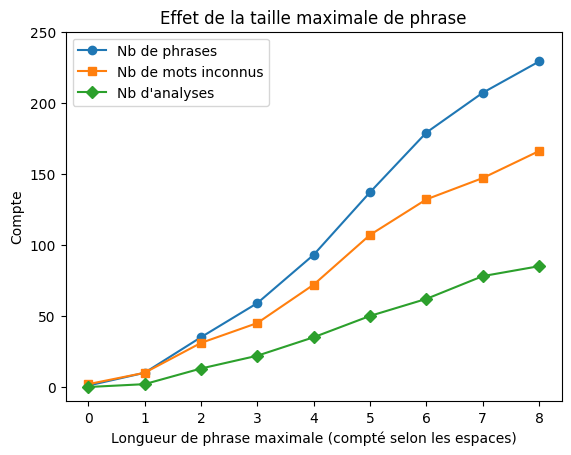

In [177]:
times = [5, 37, 84, 185, 380, 621, 894, 1076]
nb_sentences = [1, 10, 35, 59, 93, 137, 179, 207, 229]
nb_parses = list(nb_parses_dict.values())
nb_unkwords = list(nb_unkwords_dict.values())

plt.plot(nb_sentences, marker="o")
plt.plot(nb_unkwords, marker="s")
plt.plot(nb_parses, marker="D")

plt.legend(["Nb de phrases", "Nb de mots inconnus", "Nb d'analyses"])
plt.xlabel("Longueur de phrase maximale (compté selon les espaces)")
plt.ylabel("Compte")
plt.ylim([-10, 250])

plt.title("Effet de la taille maximale de phrase")

plt.show()


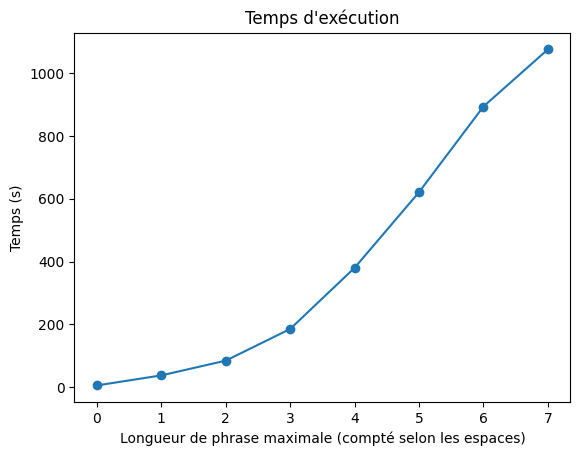

In [180]:
plt.plot(times, marker="o")
plt.xlabel("Longueur de phrase maximale (compté selon les espaces)")
plt.ylabel("Temps (s)")
plt.title("Temps d'exécution")
plt.show()

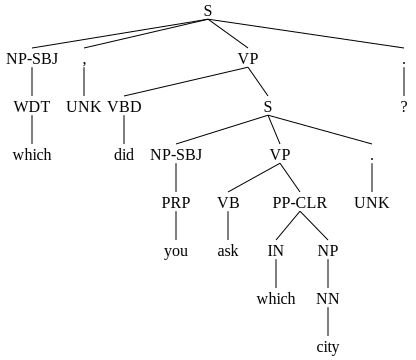

In [186]:
import random

randint = random.randint(0, len(parse_dict[9]))
parse_dict[9][randint]

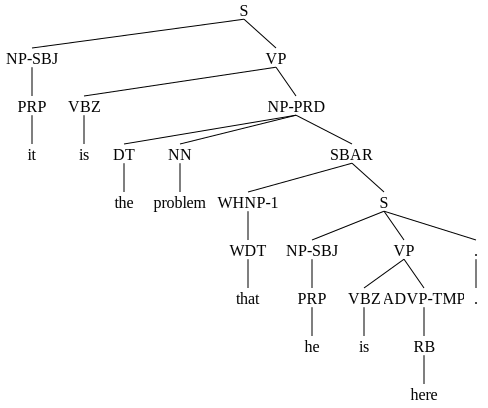

In [185]:
randint = random.randint(0, len(parse_dict[9]))
parse_dict[9][randint]